# Simulations for bimodal case

In [1]:
from AFM_lib import GenMaxwell_parabolic_LR
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import pandas as pd
import os
%matplotlib inline

path = os.getcwd()

In [2]:
#Cantilever parameters
k_m1 = 6.5
A1, A2, A3 = 230.0e-9, 6.0e-9, 0.0
Q1, Q2, Q3 = 150.0, 300.0, 450.0
fo1 = 46.0e3
fo2 = 6.27*fo1            # resonance frequency of the second eigenmode (value taken from Garcia, R., & Herruzo, E. T. (2012). The emergence of multifrequency force microscopy. Nature nanotechnology, 7(4), 217-226.)
fo3 = 17.6*fo1           # resonance frequency of the third eigenmode (value taken from Garcia, R., & Herruzo, E. T. (2012). The emergence of multifrequency force microscopy. Nature nanotechnology, 7(4), 217-226.)
k_m2 = k_m1*(fo2/fo1)**2
k_m3 = k_m1*(fo3/fo1)**2
R = 10.0e-9

period1 = 1.0/fo1
period2 = 1.0/fo2

dt = period2/10.0e3
startprint = 5.0*Q1*period1
simultime = startprint + 10.0*period1
printstep = period2/1.0e3

In [3]:
#Sample parameters polyisobutylene
df_G = pd.read_csv('PIB.txt', delimiter='\t', header=None)
tau = df_G.iloc[:,0].values
G = df_G.iloc[:,1].values
Ge = 0.0
H = 2.0e-19

In [4]:
#Running simulation with Lee&Radok scheme
os.chdir(path + '/Bimodal')
zb = A1+A2
GenMaxwell_jit = jit()(GenMaxwell_parabolic_LR)

#while zb > -20.0e-9:
#    %time t, tip, Fts, xb = GenMaxwell_jit(G, tau, R, dt, startprint, simultime, fo1, k_m1, A1, A2, A3, zb, printstep, Ge, Q1, Q2, Q3, H)
#    name = str(int(zb*1.0e9)) + '.txt'
#    np.savetxt('%s'%name, np.array((t*1.0e6, tip*1.0e9, Fts*1.0e9, xb*1.0e9)).T, delimiter='\t', header = 'time(us)\ttip(nm)\tFts(nN)\tXb(nm)')
#    zb = zb - 10.0e-9



zb = -24.0e-9
while zb > -100.0e-9:
    %time t, tip, Fts, xb = GenMaxwell_jit(G, tau, R, dt, startprint, simultime, fo1, k_m1, A1, A2, A3, zb, printstep, Ge, Q1, Q2, Q3, H)
    name = str(int(zb*1.0e9)) + '.txt'
    np.savetxt('%s'%name, np.array((t*1.0e6, tip*1.0e9, Fts*1.0e9, xb*1.0e9)).T, delimiter='\t', header = 'time(us)\ttip(nm)\tFts(nN)\tXb(nm)')
    zb = zb - 10.0e-9

Wall time: 4min 27s
Wall time: 4min 11s
Wall time: 4min 16s
Wall time: 3min 9s
Wall time: 3min 13s
Wall time: 3min 36s
Wall time: 3min 22s
Wall time: 3min 26s


## Postprocessing Results

In [5]:
from glob import glob
os.chdir(path)
from AFM_calculations import av_dt, Amp_Phase, E_diss, V_ts, Ediss_Tamayo, virial_Lozano

os.chdir(path + '/Bimodal')
files = glob('*.txt')

zeq = []
peakF = []
maxdepth = []
amp1 = []
amp2 = []
phase1 = []
phase2 = []
Ediss = []
Ediss_tamayo = []
Vdiss_lozano = []
Vdiss = []

for i in files:
    res = np.loadtxt('%s'%i, skiprows=1)
    t = res[::10,0]*1.0e-6
    dt = av_dt(t)
    
    tip = res[::10,1]*1.0e-9
    A_t1,phi_t1 = Amp_Phase(t, tip, fo1)
    A_t2,phi_t2 = Amp_Phase(t, tip, fo2)
    Fts = res[::10,2]*1.0e-9
    Ets = E_diss(tip, Fts, dt, fo1)  #dissipated energy per fundamental period
    fts_peak = Fts[np.argmax(Fts)]
    xb = res[::10,3]*1.0e-9
    tip_depth = xb[np.argmax(tip)] -xb[np.argmin(tip)]
    zb = i.rstrip('.txt')
    Vts = V_ts(tip-float(zb)*1.0e-9, Fts, dt)
    Ets_tamayo = Ediss_Tamayo(k_m1, Q1, A1, A_t1, phi_t1)
    Ets_t2 = Ediss_Tamayo(k_m2, Q2, A2, A_t2, phi_t2)
    Ets_tamayo += Ets_t2*period2/period1  #dissipated energy per fundamental period
    Vts_lozano = virial_Lozano(k_m1, Q1, A1, A_t1, phi_t1)
    vts_t2 = virial_Lozano(k_m2, Q2, A2, A_t2, phi_t2)
    Vts_lozano += vts_t2
    
    #Attaching values to arrays
    zeq.append(float(int(zb)))
    peakF.append(fts_peak)
    maxdepth.append(tip_depth)
    amp1.append(A_t1)
    amp2.append(A_t2)
    phase1.append(phi_t1)
    phase2.append(phi_t2)
    Ediss.append(Ets)
    Vdiss.append(Vts)
    Vdiss_lozano.append(Vts_lozano)
    Ediss_tamayo.append(Ets_tamayo)

zeq = np.array(zeq)
peakF= np.array(peakF)
maxdepth = np.array(maxdepth)
amp1 = np.array(amp1)
amp2 = np.array(amp2)
phase1 = np.array(phase1)
phase2 = np.array(phase2)
Ediss = np.array(Ediss)
Vdiss = np.array(Vdiss)
Vdiss_lozano = np.array(Vdiss_lozano)
Ediss_tamayo = np.array(Ediss_tamayo)

## Plotting and saving Results

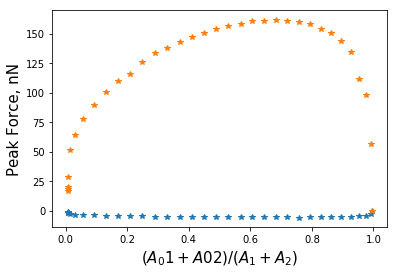

In [6]:
A1 = 230.0e-9 #amplitude of the 1st mode
A2 = 6.0e-9   #amplitude of the 2nd mode

os.chdir(path + '/Bimodal')
plt.plot( (amp1+amp2)/(A1+A2), -maxdepth*1.0e9, '*')
plt.xlabel('$(A_01+A02)/(A_1+A_2)$', fontsize =15)
plt.ylabel('Maximum Penetration, nm', fontsize=15)
plt.savefig('Max_penetration.png', bbox_inches='tight')
plt.plot( (amp1+amp2)/(A1+A2), peakF*1.0e9, '*')
plt.xlabel('$(A_01+A02)/(A_1+A_2)$', fontsize =15)
plt.ylabel('Peak Force, nN', fontsize=15)
plt.savefig('Max_Force.png', bbox_inches='tight')

z_sort = np.sort(zeq)
index = np.argsort(zeq)
maxd = []
peakforce = []
amplitude1 = []
amplitude2 = []
Ets = []
phi1 = []
phi2 = []
Vts = []
Vts_lozano = []
Ets_tamayo = []
for i in index:
    maxd.append(maxdepth[i])
    peakforce.append(peakF[i])
    amplitude1.append(amp1[i])
    amplitude2.append(amp2[i])
    Ets.append(Ediss[i])
    phi1.append(phase1[i])
    phi2.append(phase2[i])
    Ets_tamayo.append(Ediss_tamayo[i])
    Vts.append(Vdiss[i])
    Vts_lozano.append(Vdiss_lozano[i])

maxd = np.array(maxd)
peakforce = np.array(peakforce)
amplitude1 = np.array(amplitude1)
amplitude2 = np.array(amplitude2)
Ets = np.array(Ets)
phi1 = np.array(phi1)
phi2 = np.array(phi2)
Ets_tamayo = np.array(Ets_tamayo)
Vts = np.array(Vts)
Vts_lozano = np.array(Vts_lozano)

np.savetxt('Bimodal.txt', np.array(((amplitude1+amplitude2)/(A1+A2), peakforce*1.0e9, -maxd*1.0e9, phi1, phi2, Ets*1.0e18, Ets_tamayo*1.0e18, Vts*1.0e18, Vts_lozano*1.0e18 )).T, delimiter='\t', header = 'amp_ratio\tpeakF(nN)\tmaxdepth(nm)\tphase1(deg)\tphase2(deg)\tEdiss(aJ)\tEdiss_Tamayo(aJ)\tVts(aJ)\tVts_lozano(aJ)')
